In [1]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import operator
from langchain_core.tools import tool
import re

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import PydanticOutputParser

from agente_farmacia.utils.nodes import generate_csv_vector_store, generate_pdf_vector_store
#from agente_farmacia.utils.tools import vademecum_retriever_tool, forbidden_meds_retriever_tool
from agente_farmacia.utils.prompts import vademecum_prompt_template, reviewer_prompt_template, farmacia_prompt_template, fonasa_prompt_template
from agente_farmacia.utils.distance import coordenadas_direccion, get_pharmacy_data, farmacia_mas_cercana
from agente_farmacia.utils.state import AgentState, Medication

from typing import TypedDict, Annotated, Dict, List, Optional, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage

from dotenv import load_dotenv
import os
from langchain_core.tools import tool

import warnings

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    SystemMessage,
)

import time

from geopy.geocoders import Nominatim
import os 
import ssl
import certifi
import pandas as pd
import geopy.distance

# Deshabilitar la verificación SSL
ctx = ssl.create_default_context(cafile=certifi.where())
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

import pandas as pd

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from pprint import pprint

from langchain.schema import AIMessage
import requests

from IPython.display import Image, display


In [2]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GEOPY_API_KEY = os.getenv("GEOPY_API_KEY")

langchain_api_key = os.getenv('LANGCHAIN_API_KEY')

os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "DiplomadoProyFinal"
os.environ["LANGCHAIN_SESSION"] = "1"
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [3]:
# Configuración inicial de los vector stores
vademecum_vectorstore = generate_csv_vector_store('data/DrugData.csv')
restricted_med_vectorstore = generate_pdf_vector_store('data/Medicamentos_Registro_Sanitario.pdf')

# Inicializar la instancia del wrapper y asociarla con la herramienta global
global_vademecum_tool_instance = VademecumTool(vademecum_vectorstore)

# Configurar las herramientas y asociarlas con el modelo de lenguaje
tools_vademecum = [vademecum_retriever_tool]
llm_vademecum = ChatOpenAI(model="gpt-4", temperature=0).bind_tools(tools_vademecum)

# Definir el agente que utiliza la cadena configurada
def vademecum_agent(state: AgentState) -> AgentState:
    messages = state['messages']
    chain = vademecum_prompt_template | llm_vademecum
    response = chain.invoke(messages)
    return {"messages": [response], "sender": "vademecum_agent"}

# Inicializar la instancia del wrapper y asociarla con la herramienta global
global_vademecum_tool_instance = VademecumTool(vademecum_vectorstore)

# Configurar las herramientas y asociarlas con el modelo de lenguaje
tools_vademecum = [vademecum_retriever_tool]
llm_vademecum = ChatOpenAI(model="gpt-4", temperature=0).bind_tools(tools_vademecum)

# Definir una función para ejecutar la consulta
def ask_vademecum(question):
    response = vademecum_retriever_tool(question)
    return response

# Hacer una consulta
question = "¿Cuáles son los efectos secundarios del medicamento X?"
response = ask_vademecum(question)

# Imprimir la respuesta
print(response)

In [4]:
@tool
def vademecum_retriever_tool(question, k=1):
    """
    Retrieve documents from the vector store based on a given question.
    It will return documents closest to the query but may not be exact
    K must be 1 (k=1)

    Args:
        question (str): The question to retrieve documents for.
        k (int, optional): The number of documents to retrieve. Defaults to 1.

    Returns:
        list: A list of retrieved documents, each medication includes the following information
        Drug ID,Drug Name,Generic Name,Drug Class,Indications,Dosage Form,Strength,Route of Administration,
        Mechanism of Action,Side Effects,Contraindications,Interactions,Warnings and Precautions,Pregnancy Category,
        Storage Conditions,Manufacturer,Approval Date,Availability,NDC,Price
        """
    # Generate Retrieval
    retriever = vademecum_vectorstore.as_retriever(search_kwargs={"k": k})

    # Retrieve documents
    docs_response = retriever.invoke(question)

    return docs_response

tools_vademecum = [vademecum_retriever_tool]
llm_vademecum = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools_vademecum)

def vademecum_agent(state: AgentState)->AgentState:
    messages = state['messages']
    chain = vademecum_prompt_template | llm_vademecum #| parser_medicationlist
    response = chain.invoke(messages)
    return {"messages": [response], "sender": "vademecum_agent"}

In [5]:
@tool
def forbiden_meds_retriever_tool(medications: List[str], k=3):
    """
    Retrieve a list of forbidden medications for the given list of medications.
    It will return documents closest to the query using each medication as a key.
    If a medication is not in the list, then the medication is allowed.

    Args:
        medications (List[str]): A list of medications to check.
        k (int, optional): The number of documents to retrieve for each medication. Defaults to 3.

    Returns:
        Dict[str, Union[List[str], str]]: A dictionary with medication names as keys and either a list of 
        "NOT ALOWED" or "ALLOWED" as values.
    """
    results = {}
    retriever = restricted_med_vectorstore.as_retriever(search_kwargs={"k": k})

    for medication in medications:
        docs_response = retriever.invoke(medication)
        if docs_response and any(medication.lower() in doc.page_content.lower() for doc in docs_response):
            results[medication] = "NOT ALLOWED"
        else:
            results[medication] = "ALLOWED"

    return results

tools_reviewer = [forbiden_meds_retriever_tool]  # Add any necessary tools here
llm_reviewer = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools_reviewer)

def reviewer_agent(state: AgentState)->AgentState:
    messages = state['messages']
    chain = reviewer_prompt_template | llm_reviewer
    response = chain.invoke(messages)
    return {"messages": [response], "sender": "reviewer_agent"}

In [6]:
@tool
def buscar_farmacia_mas_cercana(direccion, GEOPY_API_KEY):

    """
    Encuentra la farmacia más cercana y la farmacia de turno más cercana a la dirección proporcionada.

    Args:
        direccion (str): La dirección para la cual se desea encontrar la farmacia más cercana.
        GEOPY_API_KEY (str): Clave de API de Geopy para acceder a los servicios de geocodificación.

    Returns:
        tuple: Una tupla que contiene dos diccionarios:
            - El primer diccionario contiene la información de la farmacia más cercana con las claves:
                "pharmacy_name" (str): El nombre de la farmacia.
                "address" (str): La dirección de la farmacia.
                "opening_hours" (str): El horario de apertura de la farmacia.
                "closing_hours" (str): El horario de cierre de la farmacia.
                "distance" (str): La distancia desde la dirección proporcionada a la farmacia.
            - El segundo diccionario contiene la información de la farmacia de turno más cercana con las mismas claves.
              Retorna None si no se puede encontrar la farmacia más cercana.
    """
    
    referencia = coordenadas_direccion(direccion, GEOPY_API_KEY)
    if referencia is None:
        return None

    df_farmacias = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocales.php')
    local_mas_cercano = farmacia_mas_cercana(referencia, df_farmacias)

    df_farmacias_turno = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocalesTurnos.php')
    local_mas_cercano_turno = farmacia_mas_cercana(referencia, df_farmacias_turno)

    return {
        "pharmacy_name": local_mas_cercano["local_nombre"],
        "address": local_mas_cercano["local_direccion"],
        "city":  local_mas_cercano["comuna_nombre"],
        "opening_hours": local_mas_cercano["funcionamiento_hora_apertura"],
        "closing_hours": local_mas_cercano["funcionamiento_hora_cierre"],
        "distance": local_mas_cercano["distancia"]
    }, {
        "pharmacy_name": local_mas_cercano_turno["local_nombre"],
        "address": local_mas_cercano_turno["local_direccion"],
        "city":  local_mas_cercano["comuna_nombre"],
        "opening_hours": local_mas_cercano_turno["funcionamiento_hora_apertura"],
        "closing_hours": local_mas_cercano_turno["funcionamiento_hora_cierre"],
        "distance": local_mas_cercano_turno["distancia"]
    }
    
# Vincular la herramienta con el modelo LLM
tools_farmacia = [buscar_farmacia_mas_cercana]
llm_farmacia = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools_farmacia)

# Definir el agente 'farmacia_agent'
def farmacia_agent(state: AgentState) -> AgentState:
    messages = state['messages']
    chain = farmacia_prompt_template | llm_farmacia
    response = chain.invoke(messages)
    return {"messages": [response], "sender": "farmacia_agent"}


In [7]:
@tool
def farmacias_fonasa():
    """
    Carga el dataset de farmacias que tienen convenio con FONASA por región.

    Esta función no toma argumentos. Simplemente carga y devuelve un DataFrame
    que contiene la información sobre las farmacias con cobertura FONASA 
    en distintas regiones.

    Returns:
        pd.DataFrame: Un DataFrame con la información de las farmacias que tienen 
        convenio con FONASA. El DataFrame contiene las siguientes columnas:
            - "local_nombre" (str): El nombre de la farmacia.
            - "region" (str): La región donde se encuentra la farmacia.
            - "direccion" (str): La dirección de la farmacia.
            - "coordenadas" (tuple): Las coordenadas geográficas (latitud, longitud) de la farmacia.
    """
    # Cargar el dataset de farmacias con convenio FONASA
    dataset_fonasa = pd.read_csv('data/farmacias_fonasa_region.csv', encoding='iso-8859-1', sep=';')

    return dataset_fonasa

tools_fonasa = [farmacias_fonasa]  # Add any necessary tools here
llm_fonasa = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools_fonasa)

def fonasa_agent(state: AgentState)->AgentState:
    messages = state['messages']
    chain = fonasa_prompt_template | llm_fonasa
    response = chain.invoke(messages)
    return {"messages": [response], "sender": "fonasa_agent"}

In [7]:
def buscar_farmacia_mas_cercana(direccion, GEOPY_API_KEY):

    """
    Encuentra la farmacia más cercana y la farmacia de turno más cercana a la dirección proporcionada.

    Args:
        direccion (str): La dirección para la cual se desea encontrar la farmacia más cercana.
        GEOPY_API_KEY (str): Clave de API de Geopy para acceder a los servicios de geocodificación.

    Returns:
        tuple: Una tupla que contiene dos diccionarios:
            - El primer diccionario contiene la información de la farmacia más cercana con las claves:
                "pharmacy_name" (str): El nombre de la farmacia.
                "address" (str): La dirección de la farmacia.
                "opening_hours" (str): El horario de apertura de la farmacia.
                "closing_hours" (str): El horario de cierre de la farmacia.
                "distance" (str): La distancia desde la dirección proporcionada a la farmacia.
            - El segundo diccionario contiene la información de la farmacia de turno más cercana con las mismas claves.
              Retorna None si no se puede encontrar la farmacia más cercana.
    """
    
    referencia = coordenadas_direccion(direccion, GEOPY_API_KEY)
    if referencia is None:
        return None

    df_farmacias = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocales.php')
    local_mas_cercano = farmacia_mas_cercana(referencia, df_farmacias)

    df_farmacias_turno = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocalesTurnos.php')
    local_mas_cercano_turno = farmacia_mas_cercana(referencia, df_farmacias_turno)

    return {
        "pharmacy_name": local_mas_cercano["local_nombre"],
        "address": local_mas_cercano["local_direccion"],
        "opening_hours": local_mas_cercano["funcionamiento_hora_apertura"],
        "closing_hours": local_mas_cercano["funcionamiento_hora_cierre"],
        "distance": local_mas_cercano["distancia"]
    }, {
        "pharmacy_name": local_mas_cercano_turno["local_nombre"],
        "address": local_mas_cercano_turno["local_direccion"],
        "opening_hours": local_mas_cercano_turno["funcionamiento_hora_apertura"],
        "closing_hours": local_mas_cercano_turno["funcionamiento_hora_cierre"],
        "distance": local_mas_cercano_turno["distancia"]
    }

In [18]:
# Definir la configuración del gráfico
class GraphConfig(TypedDict):
    model_name: Literal["openai"]

# Conditional edges
def should_continue(state: dict) -> Literal["tools", "__end__","vademecum_agent","farmacia_agent"]: # se agrega el agente de farmacia
    messages = state['messages']
    last_message = messages[-1]
    print("last message router ")
    print(last_message.content)
    print(last_message.tool_calls)

# Instructions:
    if "No puedo prescribir medicamentos, por favor consulta a un médico" in last_message.content:
        return "__end__"
    if "FINAL RESPONSE" in last_message.content:
        return "__end__"
    if "RE EVALUAR" in last_message.content:
        return "vademecum_agent"
    if "BUSCAR FARMACIA" in last_message.content:  # Nuevo caso para farmacia_agent
        return "farmacia_agent"
    if last_message.tool_calls:
        return "tools"
    return "__end__"

def should_continue(state: dict) -> Literal["tools", "__end__", "vademecum_agent", "farmacia_agent"]:
    messages = state['messages']
    last_message = messages[-1]
    print("last message router ")
    print(last_message.content)
    print(last_message.tool_calls)

    # Priorizar las preguntas relacionadas con farmacias
    if "BUSCAR FARMACIA" in last_message.content or "farmacia" in last_message.content.lower():
        return "farmacia_agent"  # Ir directamente al agente de farmacia

    # Evaluar condiciones específicas de medicamentos después de farmacias
    if "No puedo prescribir medicamentos, por favor consulta a un médico" in last_message.content:
        return "__end__"
    if "FINAL RESPONSE" in last_message.content:
        return "__end__"
    if "RE EVALUAR" in last_message.content:
        return "vademecum_agent"

    # Si hay una llamada a herramientas, dirígete a las herramientas
    if last_message.tool_calls:
        return "tools"
    
    return "__end__"

In [10]:
def should_continue(state: dict) -> Literal["tools", "__end__", "vademecum_agent", "farmacia_agent"]:
    messages = state['messages']
    last_message = messages[-1]
    
    # Imprimir el contenido del último mensaje para debugging
    print("Último mensaje recibido:", last_message.content)
    print("Llamadas a herramientas:", last_message.tool_calls)

    # Convertir el contenido del mensaje a minúsculas para asegurar una comparación insensible a mayúsculas/minúsculas
    content_lower = last_message.content.lower()

    # Priorizar preguntas relacionadas con farmacias
    if "farmacia" in content_lower or "buscar farmacia" in content_lower:
        print("Redirigiendo a farmacia_agent")
        return "farmacia_agent"  # Redirigir directamente al agente de farmacia

    # Evaluar condiciones de medicamentos si no se trata de farmacias
    if "no puedo prescribir medicamentos, por favor consulta a un médico" in content_lower:
        return "__end__"
    if "final response" in content_lower:
        return "__end__"
    if "re evaluar" in content_lower:
        return "vademecum_agent"
    
    # Si hay llamadas a herramientas, redirigir a 'tools'
    if last_message.tool_calls:
        return "tools"

    # Finalizar el flujo por defecto si ninguna condición se cumple
    return "__end__"

# Definir una nueva gráfica (StateGraph) utilizando la configuración y el estado del agente
workflow = StateGraph(AgentState, config_schema=GraphConfig)

workflow.add_node("vademecum_agent", vademecum_agent)
workflow.add_node("reviewer_agent", reviewer_agent)
workflow.add_node("farmacia_agent", farmacia_agent) # Nuevo agente

tools = tools_vademecum + tools_reviewer

workflow.add_node("tool_node", ToolNode(tools))

#workflow.add_conditional_edges("vademecum_agent", should_continue, {"tools": "tool_node", "__end__": "reviewer_agent"})
#workflow.add_conditional_edges("reviewer_agent", should_continue, {"tools": "tool_node", "__end__": END})

# Añadir bordes condicionales para manejar el flujo entre los nodos
workflow.add_conditional_edges("vademecum_agent", should_continue, {"tools": "tool_node", "farmacia_agent": "farmacia_agent", "__end__": "reviewer_agent"})
workflow.add_conditional_edges("reviewer_agent", should_continue, {"tools": "tool_node", "farmacia_agent": "farmacia_agent", "__end__": END})
workflow.add_conditional_edges("farmacia_agent", should_continue, {"tools": "tool_node", "__end__": END})

workflow.add_conditional_edges(
    "tool_node",

    lambda x: x["sender"],
    {
        "vademecum_agent": "vademecum_agent",
        "reviewer_agent": "reviewer_agent",
        "farmacia_agent": "farmacia_agent"
    },
)

workflow.set_entry_point("farmacia_agent")

In [10]:
# Definir la lógica condicional (should_continue)
def should_continue(state: dict) -> Literal["tools", "__end__", "vademecum_agent", "farmacia_agent"]:
    messages = state['messages']
    last_message = messages[-1]

    # Mostrar el contenido para depuración
    print("Último mensaje recibido:", last_message.content)

    # Convertir a minúsculas para asegurar comparaciones correctas
    content_lower = last_message.content.lower()

    # Redirigir a 'farmacia_agent' si la solicitud está relacionada con farmacias
    if "farmacia" in content_lower or "buscar farmacia" in content_lower:
        return "farmacia_agent"

    # Redirigir a 'vademecum_agent' o finalizar según el contenido
    if "no puedo prescribir medicamentos, por favor consulta a un médico" in content_lower:
        return "__end__"
    if "final response" in content_lower:
        return "__end__"
    if "re evaluar" in content_lower:
        return "vademecum_agent"
    
    # Redirigir a las herramientas si se hicieron llamadas a las herramientas
    if last_message.tool_calls:
        return "tools"
    
    return "__end__"


In [13]:
# Crear el flujo de trabajo (StateGraph)

workflow = StateGraph(AgentState, config_schema=GraphConfig)

# Agregar nodos de los agentes al StateGraph
workflow.add_node("vademecum_agent", vademecum_agent)
workflow.add_node("reviewer_agent", reviewer_agent)
workflow.add_node("farmacia_agent", farmacia_agent)

# Combinar las herramientas de vademecum_agent y reviewer_agent
tools = tools_vademecum + tools_reviewer + tools_farmacia

# Agregar nodo de herramientas
workflow.add_node("tool_node", ToolNode(tools))

# Definir bordes condicionales
workflow.add_conditional_edges("vademecum_agent", should_continue, {
    "tools": "tool_node", 
    "__end__": "reviewer_agent"
})

workflow.add_conditional_edges("reviewer_agent", should_continue, {
    "tools": "tool_node", 
    "__end__": END
})

workflow.add_conditional_edges("farmacia_agent", should_continue, {
    "tools": "tool_node", 
    "__end__": END
})

#workflow.add_conditional_edges("farmacia_agent", should_continue, {
#    "tools": "tool_node", 
#    "__end__": END
#})

workflow.add_conditional_edges(
    "tool_node",
    lambda x: x["sender"],
    {
        "vademecum_agent": "vademecum_agent",
        "reviewer_agent": "reviewer_agent",
        "farmacia_agent": "farmacia_agent",
    },
)

# Establecer el punto de entrada
workflow.set_entry_point("farmacia_agent")

In [8]:
# Agente supervisor
def supervisor_agent(state: AgentState) -> AgentState:
    """
    Este agente actúa como un supervisor que decide a cuál conjunto de agentes derivar la consulta
    basándose en el contenido del mensaje.

    Args:
        state (AgentState): Estado del agente, contiene los mensajes y la información.

    Returns:
        AgentState: El estado actualizado después de haber invocado el conjunto de agentes adecuado.
    """
    messages = state['messages']
    last_message = messages[-1]
    content_lower = last_message.content.lower()

    # Enrutamiento basado en el contenido de la consulta
    if "medicamento" in content_lower or "prescripción" in content_lower:
        print("Derivando al conjunto vademecum_agent -> review_agent")
        response = vademecum_agent(state)  # Invocar el primer agente del conjunto
        response = reviewer_agent(response)  # Pasar la respuesta al siguiente agente
    elif "farmacia" in content_lower or "fonasa" in content_lower:
        print("Derivando al conjunto farmacia_agent -> fonasa_agent")
        response = farmacia_agent(state)  # Invocar el primer agente del conjunto
        response = fonasa_agent(response)  # Pasar la respuesta al siguiente agente
    else:
        # Si no coincide con ninguno, retornar un mensaje de que no se puede procesar
        response = {"messages": [{"role": "system", "content": "No puedo procesar tu solicitud."}]}
    
    return response

In [22]:
def should_continue(state: dict) -> Literal["tools", "__end__", "vademecum_agent", "review_agent", "farmacia_agent", "fonasa_agent"]:
    """
    Función que decide cómo avanzar en el flujo dependiendo del agente actual y el estado del proceso.
    """
    messages = state['messages']
    last_message = messages[-1]
    content_lower = last_message.content.lower()

    print("Evaluando el siguiente paso con base en:", content_lower)

    # Si estamos en el supervisor_agent y es necesario derivar a otro agente
    if "medicamento" in content_lower or "prescripción" in content_lower:
        return "vademecum_agent"
    elif "farmacia" in content_lower or "fonasa" in content_lower:
        return "farmacia_agent"

    # Si estamos en vademecum_agent, debemos pasar a review_agent
    if last_message.sender == "vademecum_agent":
        return "review_agent"

    # Si estamos en farmacia_agent, debemos pasar a fonasa_agent
    if last_message.sender == "farmacia_agent":
        return "fonasa_agent"

    # Si estamos en review_agent o fonasa_agent, finalizamos
    if last_message.sender in ["review_agent", "fonasa_agent"]:
        return "__end__"

    return "__end__"

In [48]:
def should_continue(state: dict) -> Literal["tools", "__end__", "vademecum_agent", "reviewer_agent", "farmacia_agent", "fonasa_agent", "supervisor_agent"]:
    messages = state['messages']
    last_message = messages[-1]
    content_lower = last_message.content.lower()

    # Obtener el último agente que procesó el mensaje
    last_agent = state.get('last_agent', 'supervisor_agent')

    print(f"Último agente: {last_agent}")
    print("Evaluando el siguiente paso con base en:", last_message.content)

    # Lógica del supervisor_agent: decide si derivar a vademecum_agent o farmacia_agent
    if last_agent == "supervisor_agent":
        if "medicamento" in content_lower or "prescripción" in content_lower:
            state['last_agent'] = "vademecum_agent"
            return "vademecum_agent"
        elif "farmacia" in content_lower or "fonasa" in content_lower:
            state['last_agent'] = "farmacia_agent"
            return "farmacia_agent"
        else:
            return "__end__"

    # Lógica específica para vademecum_agent
    if last_agent == "vademecum_agent":
        if "no puedo prescribir medicamentos, por favor consulta a un médico" in last_message.content:
            return "__end__"
        if "final response" in last_message.content:
            return "__end__"
        if "re evaluar" in last_message.content:
            state['last_agent'] = "vademecum_agent"
            return "vademecum_agent"
        if last_message.tool_calls:
            return "tools"
        state['last_agent'] = "reviewer_agent"
        return "reviewer_agent"

    # Lógica específica para reviewer_agent
    if last_agent == "reviewer_agent":
        if "final response" in last_message.content:
            return "__end__"
        if last_message.tool_calls:
            return "tools"
        return "__end__"

    # Lógica específica para farmacia_agent
    if last_agent == "farmacia_agent":
        if "error" in content_lower:
            return "__end__"
        if "final response" in last_message.content:
            return "__end__"
        if "re evaluar" in content_lower:
            state['last_agent'] = "farmacia_agent"
            return "farmacia_agent"
        if last_message.tool_calls:
            return "tools"
        state['last_agent'] = "fonasa_agent"
        return "fonasa_agent"

    # Lógica específica para fonasa_agent
    if last_agent == "fonasa_agent":
        if "final response" in last_message.content:
            return "__end__"
        if last_message.tool_calls:
            return "tools"
        return "__end__"

    return "__end__"


In [53]:
def should_continue(state: dict) -> Literal["tools", "__end__", "vademecum_agent", "reviewer_agent", "farmacia_agent", "fonasa_agent", "supervisor_agent"]:
    messages = state['messages']
    last_message = messages[-1]
    content_lower = last_message["content"].lower()  # Corregido acceso a content

    # Obtener el último agente que procesó el mensaje
    last_agent = state.get('last_agent', 'supervisor_agent')

    print(f"Último agente: {last_agent}")
    print("Evaluando el siguiente paso con base en:", last_message["content"])

    # Lógica del supervisor_agent: decide si derivar a vademecum_agent o farmacia_agent
    if last_agent == "supervisor_agent":
        if "medicamento" in content_lower or "prescripción" or "efecto" in content_lower:
            state['last_agent'] = "vademecum_agent"
            return "vademecum_agent"
        elif "farmacia" in content_lower or "fonasa" in content_lower:
            state['last_agent'] = "farmacia_agent"
            return "farmacia_agent"
        else:
            return "__end__"

    # Lógica específica para vademecum_agent
    if last_agent == "vademecum_agent":
        if "no puedo prescribir medicamentos, por favor consulta a un médico" in last_message["content"]:
            return "__end__"
        if "final response" in last_message["content"]:
            return "__end__"
        if "re evaluar" in last_message["content"]:
            state['last_agent'] = "vademecum_agent"
            return "vademecum_agent"
        if last_message.get("tool_calls", None):
            return "tools"
        state['last_agent'] = "reviewer_agent"
        return "reviewer_agent"

    # Lógica específica para reviewer_agent
    if last_agent == "reviewer_agent":
        if "final response" in last_message["content"]:
            return "__end__"
        if last_message.get("tool_calls", None):
            return "tools"
        return "__end__"

    # Lógica específica para farmacia_agent
    if last_agent == "farmacia_agent":
        if "error" in content_lower:
            return "__end__"
        if "final response" in last_message["content"]:
            return "__end__"
        if "re evaluar" in content_lower:
            state['last_agent'] = "farmacia_agent"
            return "farmacia_agent"
        if last_message.get("tool_calls", None):
            return "tools"
        state['last_agent'] = "fonasa_agent"
        return "fonasa_agent"

    # Lógica específica para fonasa_agent
    if last_agent == "fonasa_agent":
        if "final response" in last_message["content"]:
            return "__end__"
        if last_message.get("tool_calls", None):
            return "tools"
        return "__end__"

    return "__end__"


In [54]:
# Definir una nueva gráfica (StateGraph) utilizando la configuración y el estado del agente
workflow = StateGraph(AgentState, config_schema=GraphConfig)

# Define los nodos de los agentes
workflow.add_node("vademecum_agent", vademecum_agent)
workflow.add_node("reviewer_agent", reviewer_agent)
workflow.add_node("farmacia_agent", farmacia_agent)
workflow.add_node("fonasa_agent", fonasa_agent)
workflow.add_node("supervisor_agent", supervisor_agent)

# Combina todas las herramientas
tools = tools_vademecum + tools_reviewer + tools_farmacia + tools_fonasa

# Nodo de herramientas
workflow.add_node("tool_node", ToolNode(tools))

# Define las transiciones para vademecum_agent -> reviewer_agent
workflow.add_conditional_edges("vademecum_agent", should_continue, {"tools": "tool_node", "__end__": "reviewer_agent"})
workflow.add_conditional_edges("reviewer_agent", should_continue, {"tools": "tool_node", "__end__": END})

# Define las transiciones para farmacia_agent -> fonasa_agent
workflow.add_conditional_edges("farmacia_agent", should_continue, {"tools": "tool_node", "__end__": "fonasa_agent"})
workflow.add_conditional_edges("fonasa_agent", should_continue, {"tools": "tool_node", "__end__": END})

# Conecta el supervisor con los agentes correspondientes
workflow.add_conditional_edges(
    "supervisor_agent", 
    should_continue, 
    {
        "vademecum_agent": "vademecum_agent", 
        "farmacia_agent": "farmacia_agent", 
        "__end__": END
    }
)

# Nodo de herramientas
workflow.add_conditional_edges(
    "tool_node",
    lambda x: x["sender"],
    {
        "vademecum_agent": "vademecum_agent",
        "reviewer_agent": "reviewer_agent",
        "farmacia_agent": "farmacia_agent",
        "fonasa_agent": "fonasa_agent",
    },
)

# Define el punto de entrada en el supervisor_agent
workflow.set_entry_point("supervisor_agent")


In [56]:
# Compilar el gráfico en un LangChain Runnable
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

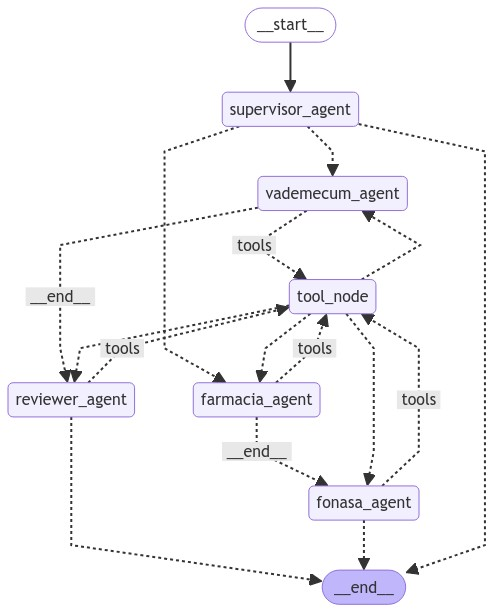

In [39]:
# Tercera iteración
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

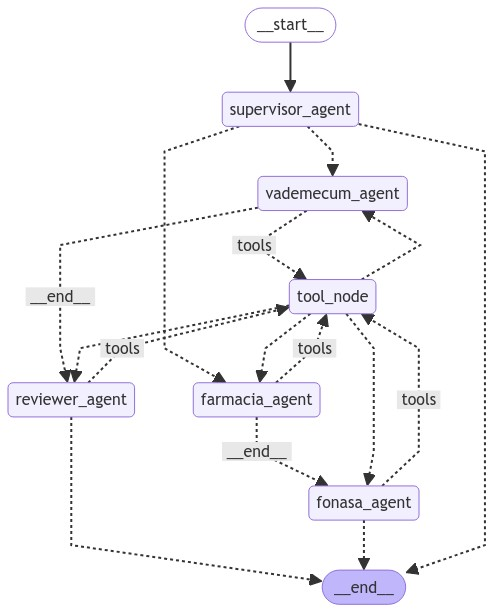

In [40]:
# Segunda iteración
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [51]:
question = "¿Cuáles son los efectos secundarios de la aspirina?"
#question = "¿Como me llamo?"

In [57]:
system_message = """
"""

start_time = time.time()
graph.invoke(
    {"messages": [SystemMessage(content=system_message), HumanMessage(content=question)]},
    config={"configurable": {"thread_id": 7}}
)

Último agente: supervisor_agent
Evaluando el siguiente paso con base en: No puedo procesar tu solicitud.


TypeError: 'AIMessage' object is not subscriptable

In [25]:
# Define la consulta inicial y el mensaje del sistema

system_message = """
"""

#start_time = time.time()

graph.invoke(
    {"messages": [SystemMessage(content=system_message), HumanMessage(content=question)]},
    config={"configurable": {"thread_id": 7}}
)

# Ejecución del workflow

#for event in graph.stream(
#    {"messages":
#      [SystemMessage(content=system_message, ),
#      HumanMessage(content=question)]},
#    config={"configurable": {"thread_id": 7}}
#):
#    for k, v in event.items():
#        if k != "__end__":
#            if 'messages' in v:
#                for message in v['messages']:
#                  if "FINAL RESPONSE" in message.content:
#                    # Wrap the text to a maximum width of 80 characters
#                    wrapped_text = textwrap.fill(message.content, width=80)
#                    print(wrapped_text)
               
#response_time = time.time()
#print(f'Tiempo para generar la respuesta: {response_time - start_time} segundos')


Último mensaje recibido: 
Llamadas a herramientas: [{'name': 'buscar_farmacia_mas_cercana', 'args': {'direccion': 'Mall Plaza Egaña', 'GEOPY_API_KEY': 'your_geopy_api_key_here'}, 'id': 'call_H44s1lgbrsWsfOzPwhDasG5j', 'type': 'tool_call'}]
Último mensaje recibido: ```json
{
  "response": "No se encontraron farmacias cercanas."
}
```
Llamadas a herramientas: []
Redirigiendo a farmacia_agent


KeyError: 'farmacia_agent'

In [ ]:
def get_pharmacy_data(api_url: str):
    
    """
    Realiza una solicitud GET a la URL de la API proporcionada y devuelve los datos en formato JSON.

    :param api_url: URL de la API a la que se realizará la solicitud.
    :return: Los datos de la respuesta en formato JSON si la solicitud es exitosa, de lo contrario, None.
    """
    try:
        response = requests.get(api_url)

        # Comprobar si la solicitud fue exitosa (código de estado 200)
        if response.status_code == 200:
            # Devolver la respuesta en formato JSON
            return pd.DataFrame(response.json())
        else:
            print(f"Error en la solicitud: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error al realizar la solicitud: {e}")
        return None

In [ ]:
def coordenadas_direccion(direccion,GEOPY_API_KEY):

    # Inicializa el geocodificador
    geolocator = Nominatim(user_agent=GEOPY_API_KEY,ssl_context=ctx)

    # Geocodifica la dirección
    ubicacion = geolocator.geocode(direccion,addressdetails=True)

    # Validación 1: Verificar si la dirección se pudo geocodificar
    if not ubicacion:
        print("Error: No se pudo encontrar la dirección. Verifica si es correcta.")
        return None

    # Obtener la dirección devuelta y las coordenadas
    direccion_devuelta = ubicacion.address
    latitud = ubicacion.latitude
    longitud = ubicacion.longitude

    # Extraer la comuna, ciudad y país desde la información cruda
    detalle = ubicacion.raw['address']
    ciudad = detalle.get('city', detalle.get('town', detalle.get('village', 'No disponible')))
    pais = detalle.get('country', 'No disponible')

    # Validación 3: Verificar componentes clave como comuna, ciudad y país
    if ciudad == 'No disponible' or pais == 'No disponible':
        print("Error: La dirección no contiene información clave como la ciudad o el país.")
        return None

    # Si pasa todas las validaciones, la dirección es válida
    print("La dirección es válida.")
    print(f"Latitud: {latitud}, Longitud: {longitud}")
    print(f"Ciudad: {ciudad}, País: {pais}")

    # Devolver las coordenadas y la información relevante
    return {
        "direccion": direccion_devuelta,
        "Latitud": latitud,
        "Longitud": longitud,
        "ciudad": ciudad,
        "pais": pais
    }

In [ ]:
def clean_coordinates(dataset, lat_col='local_lat', lng_col='local_lng'):

    df = dataset.copy()

    # Definir la condición para eliminar filas no deseadas
    condition = (
        (df[lat_col] == '') | (df[lng_col] == '') |  # Valores vacíos en local_lat o local_lng
        (df[lat_col] == '1') | (df[lng_col] == '1') |  # Valor 1 en local_lat o local_lng
        (df[lat_col] == 'Itinerante') | (df[lng_col] == 'Itinerante')  # 'Itinerante' en local_lat o local_lng
    )

    # Eliminar las filas que cumplen con la condición
    df_cleaned = df[~condition]

    # Limpiar las columnas de coordenadas
    df_cleaned[lat_col] = df_cleaned[lat_col].astype(str).str.rstrip(',').str.rstrip('°')
    df_cleaned[lng_col] = df_cleaned[lng_col].astype(str).str.rstrip(',').str.rstrip('°')

    # Función para reemplazar el cuarto carácter si es un guion
    def replace_fourth_char_if_hyphen(value):
        if len(value) > 3 and value[3] == '-':
            return value[:3] + '.' + value[4:]
        return value

    # Aplicar la transformación solo a los valores que cumplen la condición
    df_cleaned[lng_col] = df_cleaned[lng_col].apply(replace_fourth_char_if_hyphen)
    df_cleaned[lng_col] = df_cleaned[lng_col].apply(replace_fourth_char_if_hyphen)

    # Función para transformar solo los valores que comienzan con una coma
    def transform_if_needed(value):
        if isinstance(value, str) and value.startswith(','):
            return value.lstrip(',')
        return value

    # Aplicar la transformación solo a los valores que cumplen la condición
    df_cleaned[lat_col] = df_cleaned[lat_col].apply(transform_if_needed)
    df_cleaned[lng_col] = df_cleaned[lng_col].apply(transform_if_needed)

    # Reemplazar la coma por un punto
    df_cleaned[lat_col] = df_cleaned[lat_col].str.replace(',', '.', regex=False)
    df_cleaned[lng_col] = df_cleaned[lng_col].str.replace(',', '.', regex=False)

    # Convertir a float después de limpieza
    df_cleaned[lat_col] = pd.to_numeric(df_cleaned[lat_col], errors='coerce')
    df_cleaned[lng_col] = pd.to_numeric(df_cleaned[lng_col], errors='coerce')

    # Filtrar las filas con latitud y longitud fuera del rango permitido
    valid_lat_condition = df_cleaned[lat_col].between(-90, 90)
    valid_lng_condition = df_cleaned[lng_col].between(-180, 180)
    df_cleaned = df_cleaned[valid_lat_condition & valid_lng_condition]

    return df_cleaned

In [ ]:
# Función para calcular la distancia y filtrar el dataset para el local con la menor distancia

def farmacia_mas_cercana(referencia,dataset):
    
    # Leer el dataset y el archivo de referencia
    
    df = clean_coordinates(dataset)
    punto_referencia = (referencia['Latitud'], referencia['Longitud'])

    # Calcular la distancia de cada local respecto al punto de referencia
    df['distancia'] = df.apply(
        lambda row: geopy.distance.geodesic((float(row['local_lat']), float(row['local_lng'])), punto_referencia).kilometers, axis=1
    )

    # Filtrar el dataset para el local con la menor distancia
    local_mas_cercano = df.loc[df['distancia'].idxmin()]

    return local_mas_cercano

In [31]:
# direccion_input = "Que farmacia me queda cerca del Mall Plaza Egaña"
direccion_input = "Que farmacia me queda cerca del Aeropuerto Arturo Merino Benitez"

In [32]:
from agente_farmacia.utils.distance import coordenadas_direccion, get_pharmacy_data, farmacia_mas_cercana

In [33]:
model = ChatOpenAI(model="gpt-4o")

@tool
def buscar_farmacia_mas_cercana(direccion,GEOPY_API_KEY):
    
    """
    Encuentra la farmacia más cercana a la dirección proporcionada.

    Args:
        direccion (str): La dirección para la cual se quiere encontrar la farmacia más cercana.
        dataset (list): Un dataset que contiene las farmacias con sus coordenadas.

    Returns:
        dict: La farmacia más cercana con la información relevante.
    """
    # Obtener las coordenadas de la dirección proporcionada

    referencia = coordenadas_direccion(direccion,GEOPY_API_KEY)
    if referencia is None:
        return None

    # Encontrar la farmacia más cercana
    df_farmacias = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocales.php')
    local_mas_cercano = farmacia_mas_cercana(referencia,df_farmacias)

    # Encontrar la farmacia más cercana de turno
    df_farmacias_turno = get_pharmacy_data('https://midas.minsal.cl/farmacia_v2/WS/getLocalesTurnos.php')
    local_mas_cercano_turno = farmacia_mas_cercana(referencia,df_farmacias_turno)

    return local_mas_cercano, local_mas_cercano_turno


tools = [buscar_farmacia_mas_cercana]
system_message = "Eres un asistente que ayuda a encontrar farmacias cercanas basadas en la dirección proporcionada."

# Cambiar la consulta (query) usando la dirección como input
query = f"""
        Encuentra la farmacia más cercana y la farmacia más cercana de turno, a la siguiente dirección: {direccion_input}. 
        La respuesta debe venir estructurada, de la siguiente manera para la farmacia más cercana.

        - La Farmacia más cercana es: 
        - Su dirección es:
        - Su horario de Apertura es:
        - Su horario de Cierre es:
        - La distancia a su dirección de referencia es:

        Para la farmacia de turno más cercana, la respuesta debe venir estructurada así:
        
        - La Farmacia más cercana de turno es es: 
        - Su dirección es:
        - Su horario de Apertura es:
        - Su horario de Cierre es:
        - La distancia a su dirección de referencia es:

        Donde la distancia en ambos casos solo debe entregar dos decimales como máximo.
        En ningún caso deben mostrarse estos valores "**".
        """

# Crear la aplicación React con LangChain
app = create_react_agent(model, tools, state_modifier=system_message)

# Invocar la aplicación con la consulta
messages = app.invoke({"messages": [("human", query)]})

La dirección es válida.
Latitud: -33.38939795, Longitud: -70.79415901711005
Ciudad: Pudahuel, País: Chile
La dirección es válida.
Latitud: -33.38939795, Longitud: -70.79415901711005
Ciudad: Pudahuel, País: Chile


In [34]:
ai_messages = [msg for msg in messages['messages'] if isinstance(msg, AIMessage)]

In [35]:
ai_messages = [msg for msg in messages['messages'] if isinstance(msg, AIMessage)]
print(ai_messages[-1].content)

### La Farmacia más cercana es: 
- **La Farmacia más cercana es:** CRUZ VERDE
- **Su dirección es:** AEROPUERTO C.A.M. BENITEZ. LOCAL C-63, PUDAHUEL
- **Su horario de Apertura es:** 06:30:00
- **Su horario de Cierre es:** 22:00:00
- **La distancia a su dirección de referencia es:** 0.86 km

### La Farmacia más cercana de turno es: 
- **La Farmacia más cercana de turno es:** FARMAVIDA
- **Su dirección es:** AV. SANTA LUISA 226 L-B, QUILICURA
- **Su horario de Apertura es:** 08:00:00
- **Su horario de Cierre es:** 07:59:00
- **La distancia a su dirección de referencia es:** 6.28 km
